In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor


In [359]:
class Data(Dataset):
    def __init__(self, filename):
        df = pd.read_pickle(filename)
        dfx = df.drop(columns=['X'])
        dfy = df.drop(columns=['FAI', 'PA', 'A', 'Phase', 'DeltaTime'])
        
        x = dfx.iloc[:,:].values
        y = dfy.iloc[:, :].values

        x = np.array(x, dtype=np.float32)
        self.X = torch.from_numpy(x)
        self.X = torch.squeeze(self.X)

        print(f'{filename} X size: {self.X.shape}')

        outputs = []
        for i in range(len(y)):
            outputs.append(y[i, :])
            
        self.y = torch.tensor(outputs, dtype=torch.float32)
        self.y = torch.squeeze(self.y)
        self.y = torch.squeeze(self.y)
        print(f'{filename} Y size: {self.y.shape}')
        

    
    def __len__(self):
        return len(self.y)

    def __getparams__(self):
        return self.X, self.y

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



In [360]:
train_data = Data(filename='train-data-oha.pkl')
test_data = Data(filename='test-data-oha.pkl')
evaluation_data = Data(filename='eval-data-oha.pkl')

train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=True)
evaluation_dataloader = DataLoader(evaluation_data, shuffle=True)


for X, y in train_dataloader:
    print(f"Shape of X [N, Params]: {X.shape}")
    print(f"Shape of y [N, Params]: {y.shape} {y.dtype}")
    break

train-data-oha.pkl X size: torch.Size([5000, 5])
train-data-oha.pkl Y size: torch.Size([5000, 300])
test-data-oha.pkl X size: torch.Size([5000, 5])
test-data-oha.pkl Y size: torch.Size([5000, 300])
eval-data-oha.pkl X size: torch.Size([5000, 5])
eval-data-oha.pkl Y size: torch.Size([5000, 300])
Shape of X [N, Params]: torch.Size([1, 5])
Shape of y [N, Params]: torch.Size([1, 300]) torch.float32


In [361]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5, 512),
            nn.Sigmoid(),
            nn.Linear(512, 300)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5, out_features=512, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=512, out_features=300, bias=True)
  )
)


In [362]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss = loss.item()
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

In [363]:
epochs = 350
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: Avg loss: 4.154092 

Epoch 2
-------------------------------
Test Error: Avg loss: 3.979066 

Epoch 3
-------------------------------
Test Error: Avg loss: 3.928783 

Epoch 4
-------------------------------
Test Error: Avg loss: 3.842075 

Epoch 5
-------------------------------
Test Error: Avg loss: 3.817134 

Epoch 6
-------------------------------
Test Error: Avg loss: 3.763825 

Epoch 7
-------------------------------
Test Error: Avg loss: 3.745778 

Epoch 8
-------------------------------
Test Error: Avg loss: 3.685689 

Epoch 9
-------------------------------
Test Error: Avg loss: 3.647508 

Epoch 10
-------------------------------
Test Error: Avg loss: 3.627441 

Epoch 11
-------------------------------
Test Error: Avg loss: 3.605738 

Epoch 12
-------------------------------
Test Error: Avg loss: 3.568772 

Epoch 13
-------------------------------
Test Error: Avg loss: 3.554560 

Epoch 14
-------------------------------
Test E

In [364]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Shape of X [N, Params]: torch.Size([1, 5])
Shape of y [N, Params]: torch.Size([1, 300]) torch.float32
300


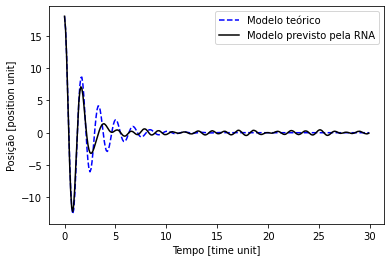

In [373]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

for X, y in evaluation_dataloader:
    print(f"Shape of X [N, Params]: {X.shape}")
    eval_x = X
    print(f"Shape of y [N, Params]: {y.shape} {y.dtype}")
    eval_y = y
    break

eval_x = eval_x.to(device)

model.eval()
with torch.no_grad():
    pred = model(eval_x)

pred = torch.squeeze(pred)
pred = torch.squeeze(pred)

pred = pred.cpu() # Para transformar em numpy, vê-se necessário passar a variável para o cpu
eval_y = eval_y.cpu()

y = pred.numpy()
eval_y = eval_y.numpy()

print(y.size)

dt = 0.1
max_time = 30
tempo = np.arange(0, max_time, dt)


plt.plot(tempo, eval_y.T, 'b--', label='Modelo teórico')
plt.plot(tempo, y, 'k-', label='Modelo previsto pela RNA')
plt.legend()
plt.xlabel("Tempo [time unit]")
plt.ylabel("Posição [position unit]")
plt.show()